# 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망 만들기

* 1986년 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합
* 텍스트 분류에 사용되는 간단한 데이터셋으로, 46개의 토픽이 존재
* 어떤 토픽은 다른 것에 비해 데이터가 많으며, 토픽당 최소 10개의 샘플이 존재
* 각 데이터 포인트가 정확히 하나의 범주로 분류됨
* **=> single-label, multiclass classification 문제**

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


2113536/2110848 [==============================] - 0s 0us/step


In [2]:
# 8,982개의 훈련 샘플과 2,246개의 테스트 샘플 존재

print(len(train_data))
print(len(test_data))

8982
2246


In [3]:
# 각 샘플은 단어 인덱스를 나타내는 정수 리스트이다.

train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [4]:
# 샘플에 연결된 레이블은 토픽의 인덱스를 나타낸다. (0~45 사이의 정수)

train_labels[10]

3

In [5]:
### 데이터 준비

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1
  print(results.shape)
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

(8982, 10000)
(2246, 10000)


In [6]:
print(x_train)
print(x_test)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


In [7]:
# one-hot encoding을 이용해 레이블 리스트를 벡터로 바꿀 수도 있다. 

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

print(one_hot_train_labels)
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [8]:
# 케라스 내장 함수를 이용한 one-hot encoding

from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(one_hot_train_labels)
print(one_hot_test_labels)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
### 모델 구성


# 모델 정의하기

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))  # output[i] : 어떤 샘플이 클래스 i에 속할 확률. 46개의 값을 모두 더하면 1이 된다.

In [10]:
# 모델 컴파일하기

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',  # 두 확률분포(네트워크가 출력한 확률분포와 실제 레이블의 분포) 사이의 거리를 측정
             metrics=['accuracy'])

In [0]:
### 훈련 검증


# 검증 세트 준비하기

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [12]:
# 모델 훈련하기

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 236us/step - loss: 2.6092 - acc: 0.4999 - val_loss: 1.6858 - val_acc: 0.6390
Epoch 2/20
7982/7982 [==============================] - 1s 129us/step - loss: 1.3912 - acc: 0.7073 - val_loss: 1.2730 - val_acc: 0.7140
Epoch 3/20
7982/7982 [==============================] - 1s 147us/step - loss: 1.0276 - acc: 0.7744 - val_loss: 1.1144 - val_acc: 0.7490
Epoch 4/20
7982/7982 [==============================] - 1s 135us/step - loss: 0.8099 - acc: 0.8259 - val_loss: 1.0141 - val_acc: 0.7720
Epoch 5/20
7982/7982 [==============================] - 1s 126us/step - loss: 0.6472 - acc: 0.8599 - val_loss: 0.9887 - val_acc: 0.7790
Epoch 6/20
7982/7982 [==============================] - 1s 125us/step - loss: 0.5217 - acc: 0.8891 - val_loss: 0.9048 - val_acc: 0.8050
Epoch 7/20
7982/7982 [===================

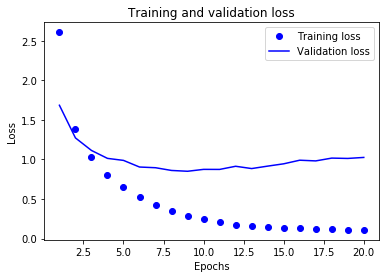

In [13]:
# 훈련과 검증 손실 그리기

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

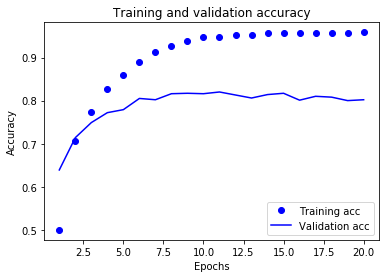

In [14]:
# 훈련과 검증 정확도 그리기

plt.clf()  # 그래프 초기화

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
# 아홉 번째 epoch 이후에 과대적합이 시작됨
# 아홉 번의 epoch으로 새로운 모델을 훈련하고, 테스트 세트로 평가

model = models.Sequential()
# 중간층의 크기는 분류할 범주의 갯수(46개)보다 많아야 네트워크에 정보의 병목이 생기지 않는다.
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
# 46개의 클래스로 데이터 포인트를 분류하려면, 네트워크의 마지막 Dense 층의 크기는 46이어야 한다.
# 단일 레이블, 다중 분류 문제에서 46개의 클래스에 대한 확률분포를 출력하기 위해 softmax 활성화 함수를 사용한다.
model.add(layers.Dense(46, activation='softmax')) 

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',  # 모델이 출력한 확률분포와 타깃분포 사이의 거리를 최소화
             metrics=['accuracy'])
model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

print(results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 149us/step - loss: 2.6512 - acc: 0.4681 - val_loss: 1.7479 - val_acc: 0.6330
Epoch 2/9
7982/7982 [==============================] - 1s 127us/step - loss: 1.4270 - acc: 0.7136 - val_loss: 1.3054 - val_acc: 0.7060
Epoch 3/9
7982/7982 [==============================] - 1s 126us/step - loss: 1.0531 - acc: 0.7788 - val_loss: 1.1163 - val_acc: 0.7570
Epoch 4/9
7982/7982 [==============================] - 1s 123us/step - loss: 0.8188 - acc: 0.8275 - val_loss: 1.0422 - val_acc: 0.7920
Epoch 5/9
7982/7982 [==============================] - 1s 125us/step - loss: 0.6518 - acc: 0.8631 - val_loss: 0.9592 - val_acc: 0.8010
Epoch 6/9
7982/7982 [==============================] - 1s 123us/step - loss: 0.5195 - acc: 0.8898 - val_loss: 0.9215 - val_acc: 0.8080
Epoch 7/9
7982/7982 [==============================] - 1s 123us/step - loss: 0.4182 - acc: 0.9134 - val_loss: 0.9057 - val_acc: 0.8090
Epoch 8

In [16]:
import copy
test_labels_copy = copy.copy(test_labels)
print(test_labels_copy)

[ 3 10  1 ...  3  3 24]


In [17]:
np.random.shuffle(test_labels_copy)
print(test_labels_copy)

hits_array = np.array(test_labels) == np.array(test_labels_copy)
print(hits_array)

[ 1  4  3 ...  3  4 16]
[False False False ...  True False False]


In [18]:
print(np.sum(hits_array))
print( float(np.sum(hits_array)) / len(test_labels) )

404
0.1798753339269813


In [21]:
# model.predict는 46개의 토픽에 대한 확률 분포를 리턴한다.


# 테스트 데이터 전체에 대한 토픽 예측

predictions = model.predict(x_test)


print(predictions[0].shape)
print(np.sum(predictions[0]))


# 가장 큰 값 => 예측 클래스 (가장 확률이 높은 클래스)

print(np.argmax(predictions[0]))  # 가장 큰 값의 인덱스를 리턴

(46,)
0.99999994
3


In [22]:
print(train_labels)

[ 3  4  3 ... 25  3 25]


In [23]:
np.array(train_labels)

array([ 3,  4,  3, ..., 25,  3, 25])